## Basic library to import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import LogLocator, NullFormatter
import pandas as pd
from scipy import optimize
from scipy.linalg import lu_factor, lu_solve
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy.special import roots_legendre
from scipy.interpolate import InterpolatedUnivariateSpline as iuSpline

## Specific library to import

In [2]:
import discretize
import empymod


## Project package to import

In [3]:
import Project
from Project import EMIP1D

In [4]:
res_air = 2e14
res_sea = 1/3
res_seafloor = 1
nlayers = 5

layer_thicknesses = 5
seabed_depth = 1000.1
depth = np.hstack([np.r_[0],seabed_depth+layer_thicknesses * np.arange(nlayers+1)])


In [5]:
t = np.logspace(-4,-2, 21)
tstrt = 1e-4
tend = 1e-2
tindex = (t >= tstrt) & (t <= tend)
tplot = t[tindex]

Configuration is inspired by JOGMEC WISTEM survey  
In this case I am using bipole so excactly as 3.5m rectangular loop  
K.Nakayama(2019)  

In [6]:

model_base = {
    'src':  [1.75,1.75,-1.75,1.75,1000, 1000],
    'rec': [0,0,1000,0,90],
    'depth': depth,
    'freqtime': t ,
    'signal': 0,
    'mrec' : True,
    'verb': 0
}

In [7]:
EMIP1D?

Init signature:
EMIP1D(
    IP_model,
    model_base,
    res_air,
    res_sea,
    res_seafloor,
    nlayers,
    tindex,
    resmin=1e-10,
    resmax=10000000000.0,
    mmin=0,
    mmax=1.0,
    taumin=1e-10,
    taumax=10000000000.0,
    cmin=0,
    cmax=1.0,
)
Docstring:     
Class for one dimensional inversion for about Induced Polarization from
Time-Domain Electromagnetic about Sea Massive Sulfide Exploration.
Forward modelling: empymod
https://empymod.emsig.xyz/en/stable/index.html

Forward modelling: SimPEG

Inversion
    Jacobian is approximated by finite difference
    Objective function: f = 0.5*( phid + beta* phim)
    Data part: phid = (Wd(F(m)-dobs))**2
    Model part: phim = (Ws(mref-minit))**2

Parameters

IP_model: String
    "cole":
        res0: resistivity in low frequency
        res8: resistivity in hig frequency
        tau : time constant
        c   : relaxation parameter

    "pelton":
        res : resistivity
        m   : chargeability
        tau : time co

In [8]:
EMIP =  EMIP1D("pelton",model_base,
    res_air,res_sea,res_seafloor,nlayers,tindex)

In [9]:
res = 1/10 * np.ones(nlayers)
#res = np.r_[0.1,0.1,0.5,0.5,1.0]
mvec_r = np.log(res)

mvec_m = 0.6 * np.ones(nlayers)
#mvec_m = np.r_[0.6,0.6,0.2,0.2,0.0]
mvec_t = np.log(1e-4)*np.ones(nlayers)
mvec_c = 0.5*np.ones(nlayers)

mvec_obs = np.hstack([mvec_r, mvec_m, mvec_t, mvec_c])
data_clean = EMIP.predicted_data(mvec_obs)

Add gaussian noise

In [10]:
relative_error=0.05
np.random.seed(0)
data_obs =  data_clean + np.random.randn(len(data_clean)) * relative_error * np.abs(data_clean)

Prepare initial model

In [11]:
res = np.ones(nlayers)
mvec_r = np.log(res)
mvec_m = 0.0* np.ones(nlayers)
mvec_t = np.log(1e-3)*np.ones(nlayers)
mvec_c = 0.6*np.ones(nlayers)
mvec_init = np.hstack([mvec_r, mvec_m, mvec_t, mvec_c])
data_init = EMIP.predicted_data(mvec_init)


Inversion using GaussNewton method

In [12]:
EMIP.GaussNewton_Reg_LS?

Signature:
EMIP.GaussNewton_Reg_LS(
    dobs,
    model_init,
    niter,
    beta,
    alpha0=1,
    afac=0.5,
    atol=1e-06,
    gtol=0.001,
    mu=0.0001,
)
Docstring:
""
Gauss-Newton method
Line search method Amijo using directional derivative

parameter
    dobs: data
    model_init: initial model
    mref : applly initial model as reference model
    niter: max iteration number
    beta: beta for model part
    alpha0: initial alpha for line search
    afac: backtracking factor
    atol: min value for alpha
    gtol: minimum value for dradient, stopping criteria for inversion
    mu: parameter for directional derivative
File:      c:\users\81805\onedrive\33_ubc\06_eosc556\pycharm\project.py
Type:      method

In [14]:
niter = 20
beta = 1
#model_SD, error, model_itr = EMIP.steepest_descent_linesearch(data_obs, model_init, niter)
mvec_pred, error, model_itr = EMIP.GaussNewton_Reg_LS(
    dobs=data_obs, model_init=mvec_init, niter=niter,beta=beta,
    atol=1e-14, mu= 1e-4
)

Gauss-Newton 
 Initial phid = 1.71e+04 ,phim = 0.00e+00, error= 1.71e+04 
  1, alpha:1.25e-01, gradient:6.39e+03, phid:1.13e+04, phim:7.11e+00, f:1.13e+04 
  2, alpha:6.25e-02, gradient:1.44e+05, phid:1.06e+04, phim:6.22e+00, f:1.06e+04 
  3, alpha:3.12e-02, gradient:1.47e+05, phid:1.03e+04, phim:5.86e+00, f:1.03e+04 
  4, alpha:3.12e-02, gradient:1.50e+05, phid:1.03e+04, phim:5.55e+00, f:1.03e+04 
  5, alpha:1.56e-02, gradient:1.60e+05, phid:1.03e+04, phim:5.42e+00, f:1.03e+04 
  6, alpha:7.81e-03, gradient:1.68e+05, phid:1.02e+04, phim:5.37e+00, f:1.02e+04 
  7, alpha:3.91e-03, gradient:1.73e+05, phid:1.02e+04, phim:5.34e+00, f:1.02e+04 
  8, alpha:3.91e-03, gradient:1.77e+05, phid:1.02e+04, phim:5.32e+00, f:1.02e+04 
  9, alpha:3.91e-03, gradient:1.81e+05, phid:1.01e+04, phim:5.31e+00, f:1.02e+04 
 10, alpha:3.91e-03, gradient:1.85e+05, phid:1.01e+04, phim:5.30e+00, f:1.01e+04 
 11, alpha:3.91e-03, gradient:1.90e+05, phid:1.01e+04, phim:5.30e+00, f:1.01e+04 
 12, alpha:7.81e-03, gra

In [15]:
data_pred = (EMIP.predicted_data(model_pred))

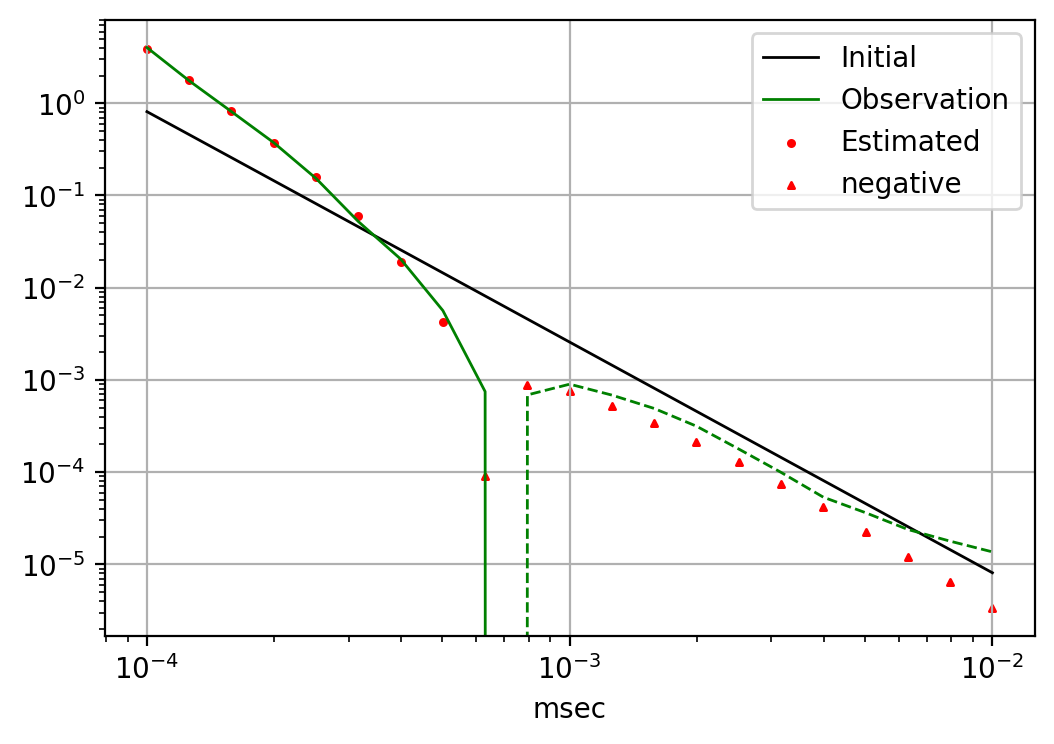

In [16]:
plt.figure(figsize=(6, 4),dpi=200)

plt.plot(tplot, data_init, "-", color="k", label="Initial", linewidth=1)
plt.plot(tplot, -data_init, "--", color="k", linewidth=1)

plt.plot(tplot, data_obs, "-", color="g", label="Observation", linewidth=1)
plt.plot(tplot, -data_obs, "--", color="g", linewidth=1)

plt.scatter(tplot, data_pred, color="r", label="Estimated", marker='o', s=5)
plt.scatter(tplot, -data_pred,  color="r", label="negative",marker='^', s=5)
plt.xlabel("msec")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()


In [17]:
model_init =  EMIP.ip_model(mvec_init)
model_obs  =  EMIP.ip_model(mvec_obs)
model_pred  =  EMIP.ip_model(mvec_pred)

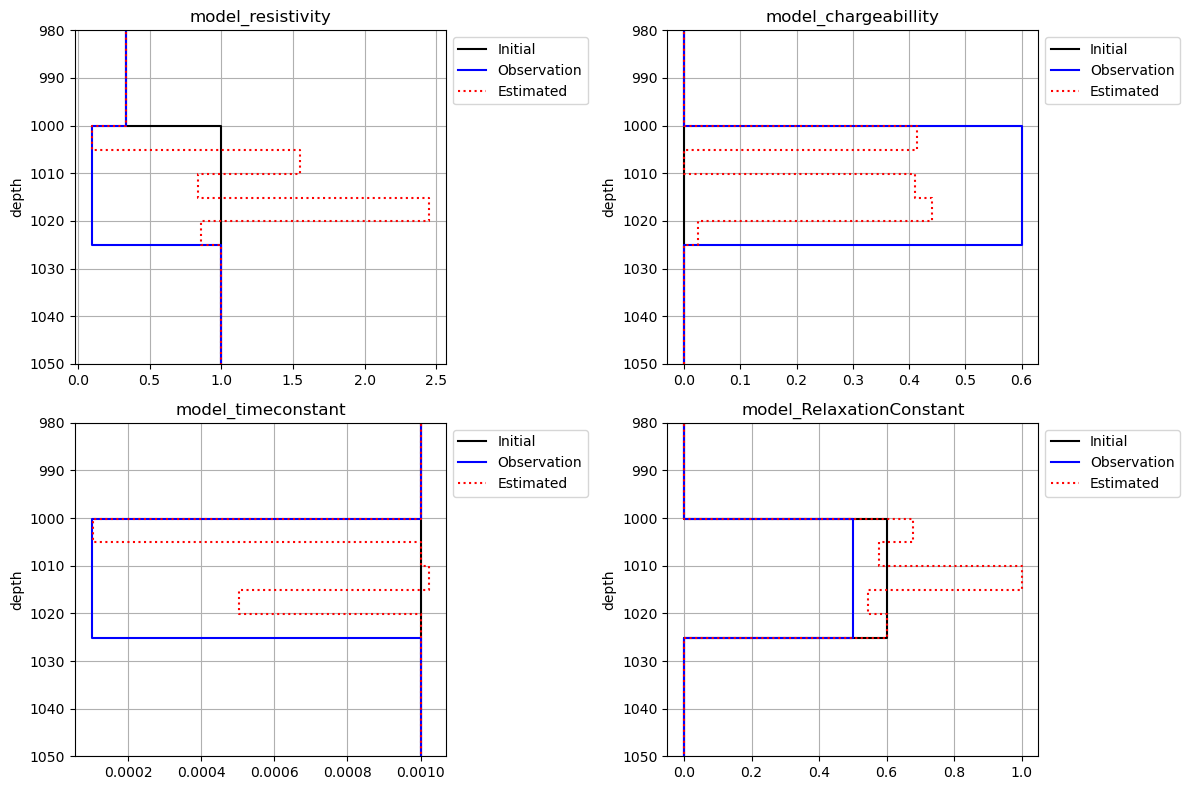

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

#plot_model_m(model_base["depth"], model_ip["res"], ax[0], "resistivity","k")
EMIP.plot_model(model_init["res"], ax[0,0],"Initial","k-")
EMIP.plot_model(model_obs["res"] , ax[0,0],"Observation","b-")
EMIP.plot_model(model_pred["res"], ax[0,0],"Estimated","r:")

EMIP.plot_model(model_init["m"], ax[0,1],"Initial","k-")
EMIP.plot_model(model_obs["m"]  ,ax[0,1],"Observation","b-")
EMIP.plot_model(model_pred["m"], ax[0,1],"Estimated","r:")

EMIP.plot_model(model_init["tau"], ax[1,0],"Initial","k-")
EMIP.plot_model(model_obs["tau"]  ,ax[1,0],"Observation","b-")
EMIP.plot_model(model_pred["tau"], ax[1,0],"Estimated","r:")
    
EMIP.plot_model(model_init["c"], ax[1,1],"Initial","k-")
EMIP.plot_model(model_obs["c"]  ,ax[1,1],"Observation","b-")
EMIP.plot_model(model_pred["c"], ax[1,1],"Estimated","r:")
    
    
ax[0,0].set_title("model_resistivity")
ax[0,1].set_title("model_chargeabillity")
ax[1,0].set_title("model_timeconstant")
ax[1,1].set_title("model_RelaxationConstant")

for i in range(2):  # Iterate over rows
    for j in range(2):  # Iterate over columns
        ax[i, j].set_ylim([1050, 980])
        ax[i, j].set_ylabel('depth')
        ax[i, j].legend(loc='upper left', bbox_to_anchor=(1, 1))
        ax[i, j].grid()


plt.tight_layout()